In [1]:
from pathlib import Path

import matplotlib.pyplot as plt
import numba
import numpy as np
import pandas as pd
import pyarrow as pa
import torch
from dask.distributed import Client
from nested_pandas import NestedFrame, NestedDtype
from scipy.stats import norm

from uncle_val.datasets.dp1 import dp1_catalog_multi_band
from uncle_val.whitening import whiten_data

In [2]:
dp1_root = Path("../../data/dp1")
BANDS = "ugrizy"
MIN_N_SRC = 10
# torch.load("model.pt", weights_only=False) OR None
MODEL = torch.load("model.pt", weights_only=False)

In [3]:
catalog = dp1_catalog_multi_band(
    dp1_root,
    bands=BANDS,
    obj="science",
    img="cal",
    phot="PSF",
    mode="forced",
)
catalog

,id,coord_ra,coord_dec,lc,band,object_mag,extendedness,is_u_band,is_g_band,is_r_band,is_i_band,is_z_band,is_y_band
npartitions=389,,,,,,,,,,,,,
"Order: 6, Pixel: 130",int64[pyarrow],double[pyarrow],double[pyarrow],"nested<x: [float], err: [float]>",object,float[pyarrow],float[pyarrow],bool,bool,bool,bool,bool,bool
"Order: 8, Pixel: 2176",...,...,...,...,...,...,...,...,...,...,...,...,...
...,...,...,...,...,...,...,...,...,...,...,...,...,...
"Order: 9, Pixel: 2302101",...,...,...,...,...,...,...,...,...,...,...,...,...
"Order: 7, Pixel: 143884",...,...,...,...,...,...,...,...,...,...,...,...,...


In [4]:
numba_whiten_data = numba.njit(whiten_data)


def whiten_original_flux_err(flux, err):
    return numba_whiten_data(flux, np.square(err), np=None)


def whiten_corrected_flux_err(flux, err):
    x = torch.tensor(np.stack([flux, err], axis=-1, dtype=np.float32))
    u = MODEL(x)[..., 0].cpu().detach().numpy()
    corrected_err = u * err
    return numba_whiten_data(flux, np.square(corrected_err), np=None)


whiten_flux_err = whiten_original_flux_err if MODEL is None else whiten_corrected_flux_err


def samples_in_bins(x, bins, sample_count, rng):
    bin_idx = np.digitize(x, bins)
    samples = []
    for i in range(len(bins) - 1):
        n_in_bin = np.count_nonzero(bin_idx == i)
        n_sample = min(sample_count, n_in_bin)
        idx = rng.choice(n_in_bin, n_sample, replace=False)
        samples.append(idx)
    return samples


def extract_hists(df, pixel, *, z_bins, mag_bins, bands, min_n_src, n_samples=10, non_extended):
    rng = np.random.default_rng((pixel.order, pixel.pixel))

    df = df[df["lc"].nest.list_lengths >= min_n_src]

    if non_extended:
        df = df.query("extendedness == 0.0")

    if len(df) == 0:
        return pd.DataFrame(
            {
                "mag_bin_idx": np.array([], dtype=int),
                "band": np.array([], dtype=str),
                "hist": NestedDtype(
                    pa.struct({"z_bin_idx": pa.list_(pa.int64()), "count": pa.list_(pa.int64())})
                ),
                "samples": NestedDtype(
                    pa.struct({"z": pa.list_(pa.float64()), "object_mag": pa.list_(pa.float64())})
                ),
            }
        )

    whiten = (
        df.reduce(
            lambda x, err: {"whiten.z": whiten_flux_err(x, err)},
            "lc.x",
            "lc.err",
            append_columns=True,
        )
        .drop(
            columns=["lc"],
        )
        .reset_index(
            drop=True,
        )
    )

    mag_idx_grid, z_idx_grid = np.indices((len(mag_bins) - 1, len(z_bins) - 1))

    result_nfs = []
    for band in bands:
        monochrome = whiten.query(f"band=='{band}'")
        z_mag = monochrome[["object_mag"]].join(monochrome["whiten"].nest.to_flat())
        hist, _mag_bins, _z_bins = np.histogram2d(z_mag["object_mag"], z_mag["z"], bins=[mag_bins, z_bins])
        flat_df = pd.DataFrame(
            {
                "band": band,
                "mag_bin_idx": mag_idx_grid.flatten(),
                "z_bin_idx": z_idx_grid.flatten(),
                "count": hist.flatten().astype(np.int64),
            }
        )
        nf = NestedFrame.from_flat(
            flat_df,
            name="hist",
            base_columns=["band"],
            nested_columns=["z_bin_idx", "count"],
            on="mag_bin_idx",
        ).reset_index(drop=False)
        sample_idx = samples_in_bins(
            x=z_mag["object_mag"],
            bins=mag_bins,
            sample_count=n_samples,
            rng=rng,
        )
        nf["z"] = pd.Series(
            [np.asarray(z_mag["z"].iloc[idx]) for idx in sample_idx],
            dtype=pd.ArrowDtype(pa.list_(pa.float64())),
        )
        nf["object_mag"] = pd.Series(
            [np.asarray(z_mag["object_mag"].iloc[idx]) for idx in sample_idx],
            dtype=pd.ArrowDtype(pa.list_(pa.float64())),
        )
        nf = nf.nest_lists(["z", "object_mag"], name="samples")

        result_nfs.append(nf)
    return pd.concat(result_nfs, ignore_index=True)

In [5]:
z_bins = np.r_[-10:10:1001j]
z_width = z_bins[1] - z_bins[0]
z_centers = 0.5 * (z_bins[1:] + z_bins[:-1])

mag_bins = np.arange(13, 27, 0.5)
mag_width = mag_bins[1] - mag_bins[0]
mag_centers = 0.5 * (mag_bins[1:] + mag_bins[:-1])

hists = catalog.map_partitions(
    extract_hists,
    z_bins=z_bins,
    mag_bins=mag_bins,
    bands=BANDS,
    min_n_src=MIN_N_SRC,
    non_extended=True,
    include_pixel=True,
)

In [6]:
with Client(n_workers=8, threads_per_worker=1, memory_limit="8GB") as client:
    display(client)
    hists_df = hists.compute()
hists_df.head(5)

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:8787/status,
Dashboard: http://127.0.0.1:8787/status,Workers: 8
Total threads: 8,Total memory: 59.60 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:53742,Workers: 0
Dashboard: http://127.0.0.1:8787/status,Total threads: 0
Started: Just now,Total memory: 0 B
Comm: tcp://127.0.0.1:53770,Total threads: 1
Dashboard: http://127.0.0.1:53772/status,Memory: 7.45 GiB
Nanny: tcp://127.0.0.1:53745,


/Users/hombit/projects/lincc-frameworks/uncle-val/src/uncle_val/whitening.py:64: NumbaPerformanceWarning: '@' is faster on contiguous arrays, called on (Array(float64, 2, 'A', False, aligned=True), Array(float64, 2, 'C', False, aligned=True))
  decomposed = _stable_decomposition(v, np=np)
/Users/hombit/projects/lincc-frameworks/uncle-val/src/uncle_val/whitening.py:64: NumbaPerformanceWarning: '@' is faster on contiguous arrays, called on (Array(float64, 2, 'A', False, aligned=True), Array(float64, 2, 'F', False, aligned=True))
  decomposed = _stable_decomposition(v, np=np)
/Users/hombit/projects/lincc-frameworks/uncle-val/src/uncle_val/whitening.py:64: NumbaPerformanceWarning: '@' is faster on contiguous arrays, called on (Array(float64, 2, 'C', False, aligned=True), Array(float64, 2, 'A', False, aligned=True))
  decomposed = _stable_decomposition(v, np=np)
/Users/hombit/projects/lincc-frameworks/uncle-val/src/uncle_val/whitening.py:64: NumbaPerformanceWarning: '@' is faster on contigu

mag_bin_idx band                                       hist samples
0            0    u  [{z_bin_idx: 0, count: 0}; …] (1000 rows)      []
1            1    u  [{z_bin_idx: 0, count: 0}; …] (1000 rows)      []
2            2    u  [{z_bin_idx: 0, count: 0}; …] (1000 rows)      []
3            3    u  [{z_bin_idx: 0, count: 0}; …] (1000 rows)      []
4            4    u  [{z_bin_idx: 0, count: 0}; …] (1000 rows)      []

In [7]:
def aggregate_hists(df, band):
    df = (
        df.drop(columns=["samples"])
        .query(
            f"band == {band!r}",
        )
        .explode("hist")
        .groupby(
            ["z_bin_idx"],
        )["count"]
        .sum()
        .sort_index()
        .reset_index(
            drop=False,
        )
    )
    df["z_centers"] = z_centers
    df["prob"] = df["count"] / df["count"].sum()
    df["prob_dens"] = df["prob"] / z_width

    mean = np.sum(df["prob"] * df["z_centers"])
    std = np.sqrt(np.sum(df["prob"] * (df["z_centers"] - mean) ** 2))

    return df, mean, std


def plot_hist(df, ax, band):
    df, mean, std = aggregate_hists(df, band)
    print(mean, std)

    ax.set_title(f"{band}-band, mean={mean:.4f}, std={std:.4f}")
    ax.bar(x=df["z_centers"], height=df["prob_dens"], width=z_width, label="data", color="gray", alpha=0.4)
    ax.plot(z_bins, norm(loc=mean, scale=std).pdf(z_bins), label="Gaussian PDF fit", color="black", alpha=1.0)
    ax.plot(z_bins, norm(loc=0, scale=1).pdf(z_bins), label="Standard PDF", color="blue", alpha=0.6)
    ax.legend()


def plot_magn_vs_uu(df, ax, band):
    uu = []
    for mag_bin_idx in range(len(mag_bins) - 1):
        _df, _mean, std = aggregate_hists(df.query(f"mag_bin_idx == {mag_bin_idx}"), band)
        uu.append(std)
    uu = np.array(uu)

    mag_, uu = mag_centers[uu > 0], uu[uu > 0]

    samples_mag = df.query(f"band == {band!r}")["samples.object_mag"]
    samples_z = df.query(f"band == {band!r}")["samples.z"]

    ax.set_title(f"{band}-band")
    ax.scatter(samples_mag, samples_z, color="grey", marker=".", s=1, alpha=0.5, label="Samples")
    ax.hlines([1.0, -1.0], *ax.get_xlim(), color="red", ls="--", alpha=0.3)
    ax.plot(mag_, uu, color="blue", label="Std (uncertainty underestimation)")
    ax.plot(mag_, -uu, color="blue")
    ax.set_xlabel("Object PSF Magnitude")
    ax.set_ylabel("Whiten Signal")
    ax.set_ylim([z_bins[0], z_bins[-1]])
    ax.set_xlim([mag_bins[0], mag_bins[-1]])
    ax.legend()

## Plot overall histograms

0.03305623512619671 0.7310573489254076
0.005959829964311492 0.5832990865846841
0.007369232435924106 0.5558237533989125
0.01172971375984913 0.5136889292514725
0.020232585715732 0.4885466611680079
0.05708000879605396 0.5709855522977


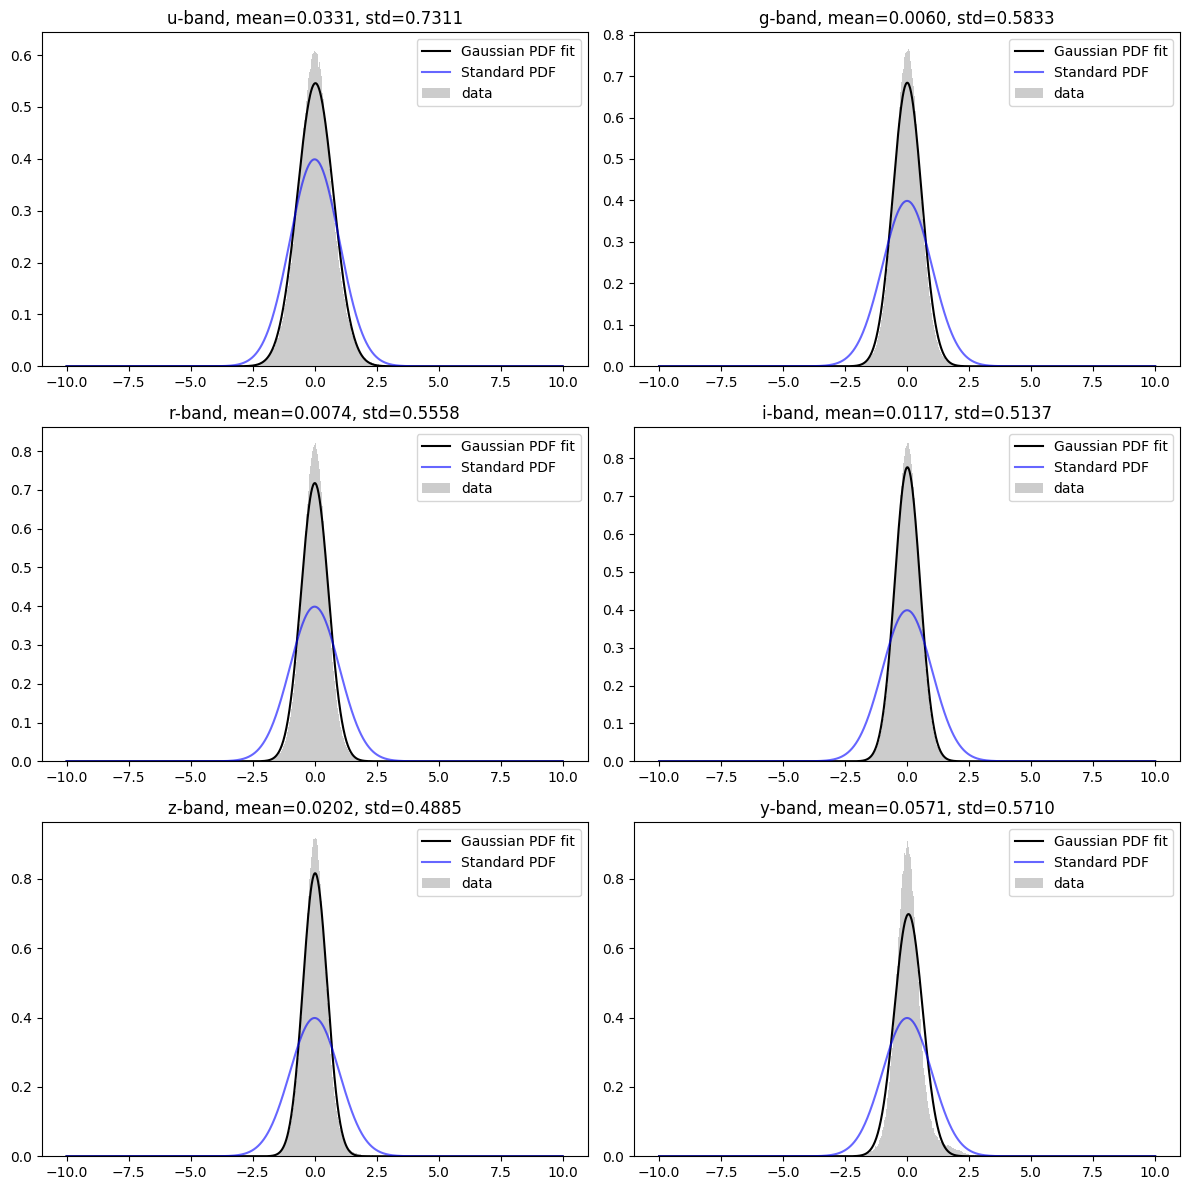

In [8]:
fig, axes = plt.subplots(3, 2, figsize=(12, 12))
axes = axes.flatten()

for i, band in enumerate(BANDS):
    plot_hist(hists_df, axes[i], band)

plt.tight_layout()
plt.show()

## Plot for a magnitude bin

0.006512046026609347 0.4780002117049244
0.0006407388013521531 0.48701061982402416
0.009280390974743369 0.48011566692819346
0.006029625590694504 0.4025560072818849
0.004896204232448978 0.3438846882995256
0.018632775497316262 0.354327827916773


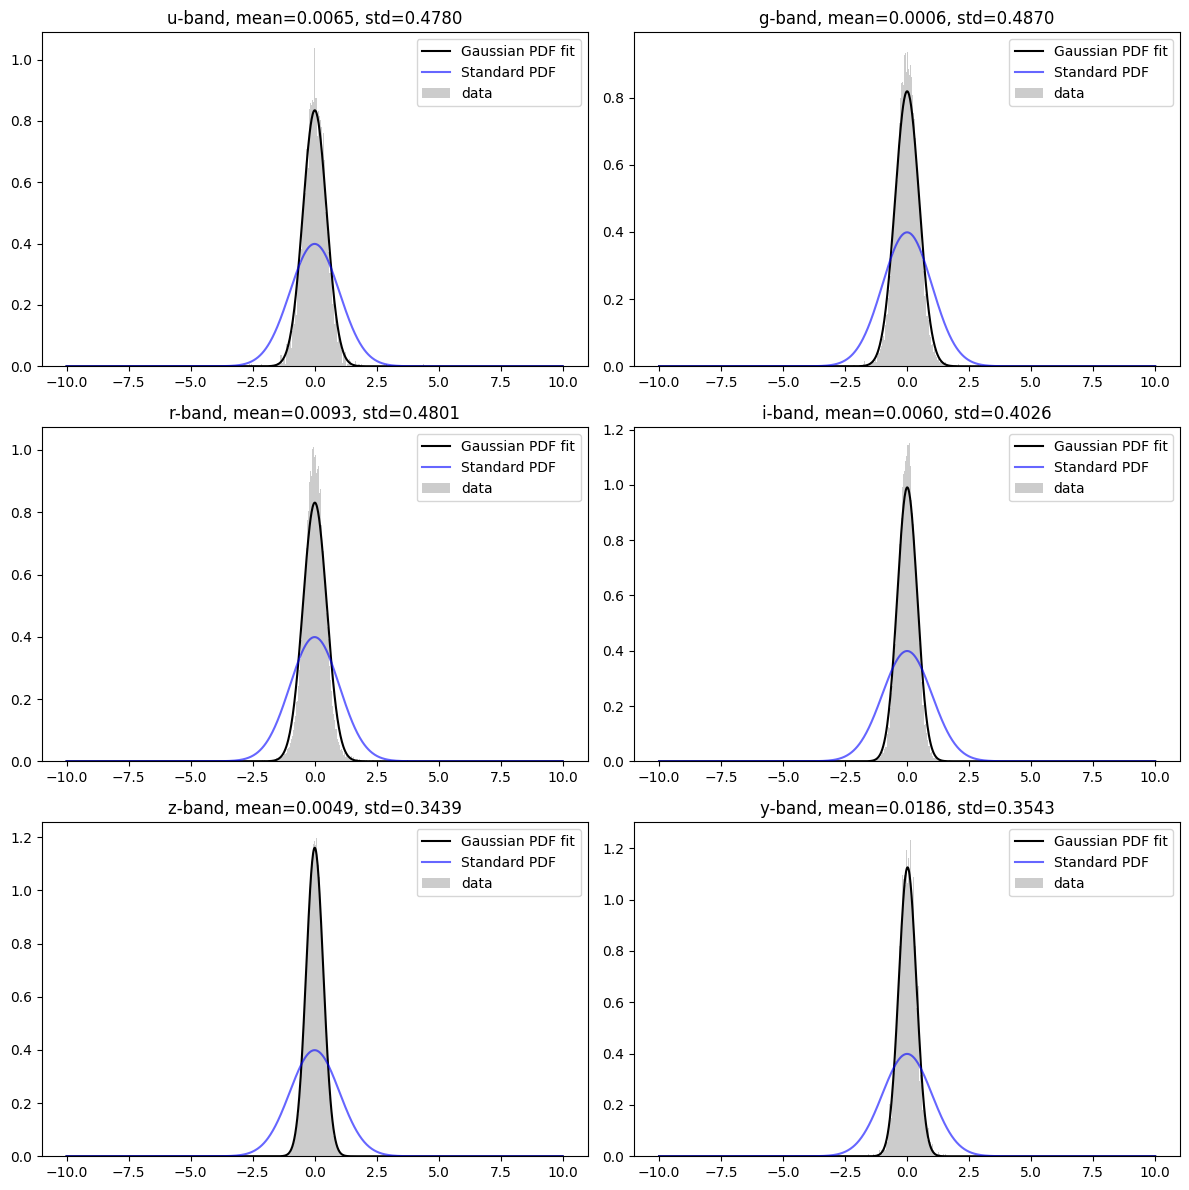

In [9]:
MAG = 21
mag_bin_idx = np.searchsorted(mag_bins, MAG)

fig, axes = plt.subplots(3, 2, figsize=(12, 12))
axes = axes.flatten()

for i, band in enumerate(BANDS):
    plot_hist(hists_df.query(f"mag_bin_idx == {mag_bin_idx}"), axes[i], band)

plt.tight_layout()
plt.show()

## Plot UU as a function of magnitude

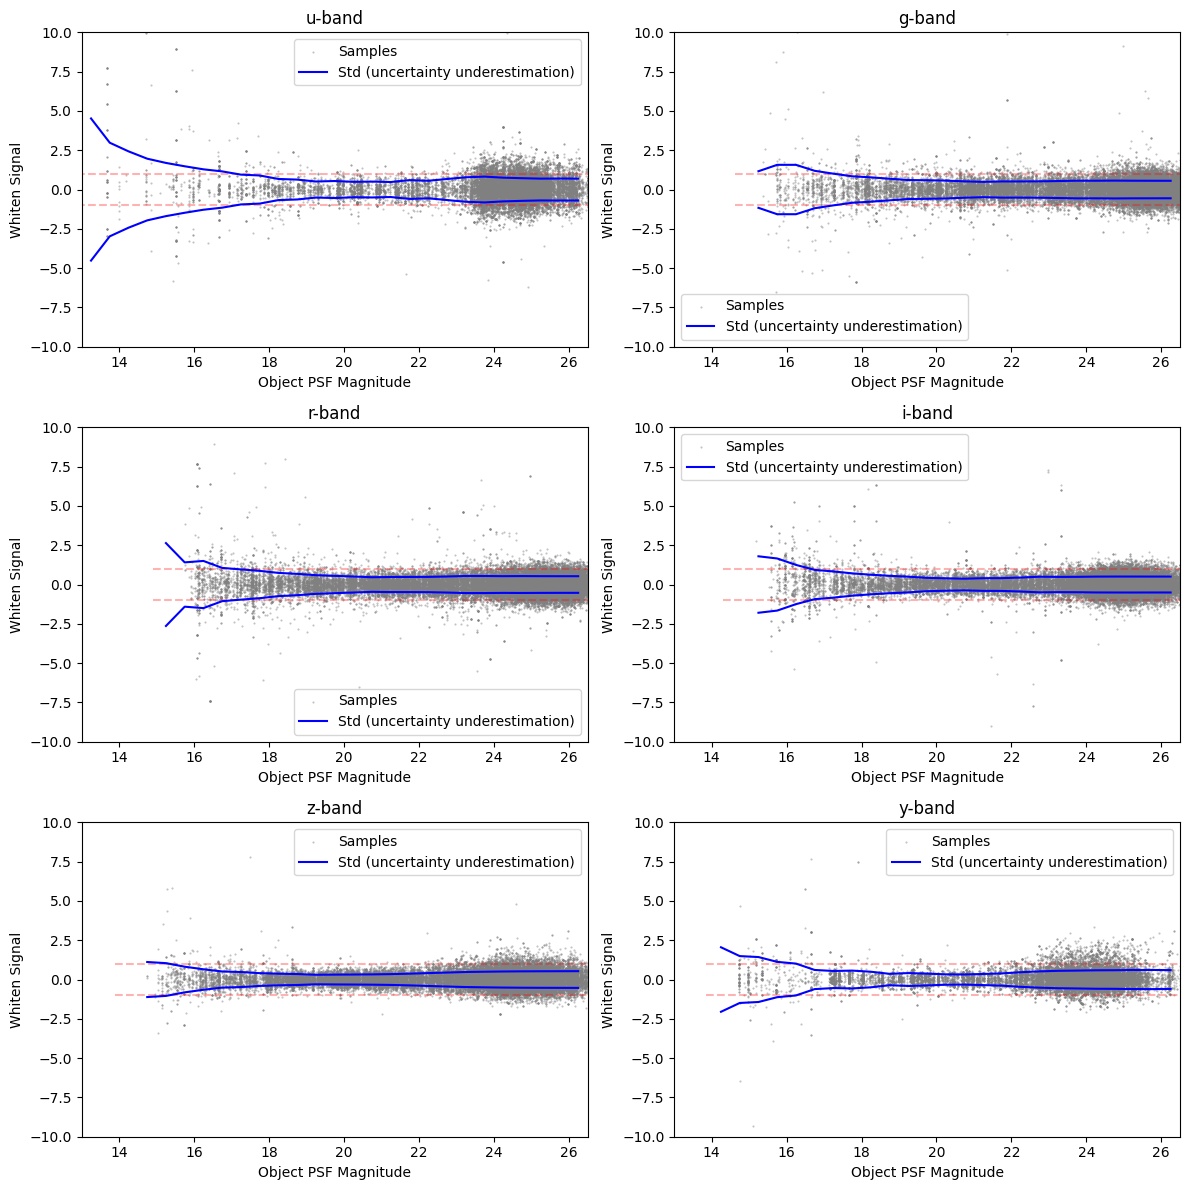

In [10]:
fig, axes = plt.subplots(3, 2, figsize=(12, 12))
axes = axes.flatten()

for i, band in enumerate(BANDS):
    plot_magn_vs_uu(hists_df, axes[i], band)

plt.tight_layout()
plt.show()